# EDA for CHGH dataset

In [1]:
!nvidia-smi

Fri Feb 17 02:40:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:85:00.0 Off |                    0 |
| N/A   33C    P0    44W / 163W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup Environment

In [1]:
# mount driver
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/CardiacSeg/eda/CHGH

# # install dependents
# !pip install -q "monai-weekly[nibabel, tqdm, einops]"
# !python -c "import matplotlib" || pip install -q matplotlib
import matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

## Import Library

In [48]:
import sys
import os
# set package path
sys.path.append("/nfs/Workspace/CardiacSeg")

from monai.data import CacheDataset, DatasetSummary, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.chgh_dataset import get_data_dicts, get_multiple_label_data_dicts, multi_label_to_label_pred_data_dicts
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info
from data_utils.io import load_json

## Prepare data dicts

In [7]:
root_data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh'
data_dir = os.path.join(root_data_dir, 'block_06')
data_dicts_json = os.path.join(root_data_dir, 'data_dicts', 'exp_2_2.json')

In [15]:
# data_dicts = load_json(data_dicts_json)
# data_dicts = get_data_dicts(data_dir)

In [51]:
data_dicts = get_multiple_label_data_dicts(data_dir)
data_dicts = multi_label_to_label_pred_data_dicts(data_dicts)
data_dicts

[{'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_gt.nii.gz',
  'pred': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_pwsb.nii.gz'},
 {'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_gt.nii.gz',
  'pred': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_t.nii.gz'},
 {'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_gt.nii.gz',
  'pred': '/nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000_ts.nii.gz'}]

In [6]:
# get train data
data_dicts = data_dicts[:-2]

## Show data info

/opt/conda/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


pid: pid_1000
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000.nii.gz
img shape: [512, 512, 357]
img spacing: [0.36914062, 0.36914062, 0.4]
lbl shape: [512, 512, 357]
lbl spacing: [0.36914062, 0.36914062, 0.4]
lbl ids: [0. 1.]


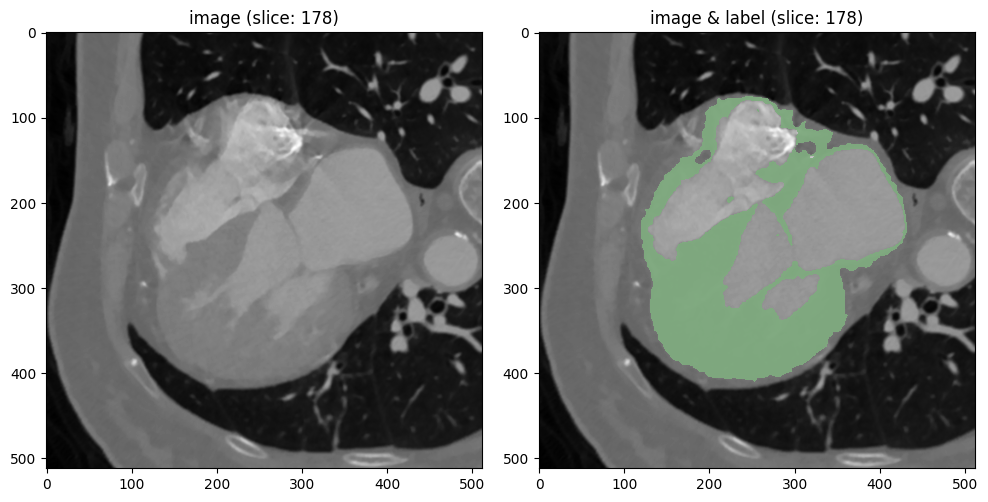

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1000
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000.nii.gz
img shape: [512, 512, 357]
img spacing: [0.36914062, 0.36914062, 0.4]
lbl shape: [512, 512, 357]
lbl spacing: [0.36914062, 0.36914062, 0.4]
lbl ids: [0. 1.]


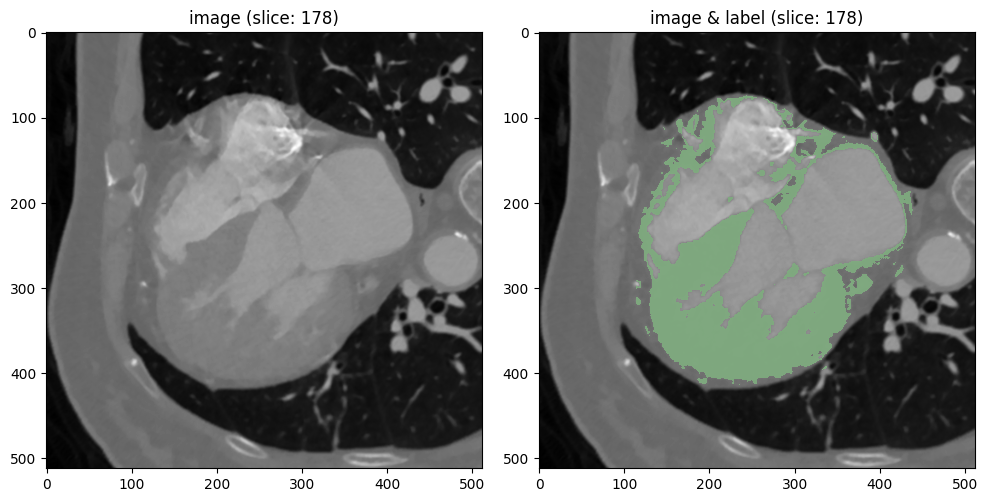

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1000
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000.nii.gz
img shape: [512, 512, 357]
img spacing: [0.36914062, 0.36914062, 0.4]
lbl shape: [512, 512, 357]
lbl spacing: [0.36914062, 0.36914062, 0.4]
lbl ids: [0. 1.]


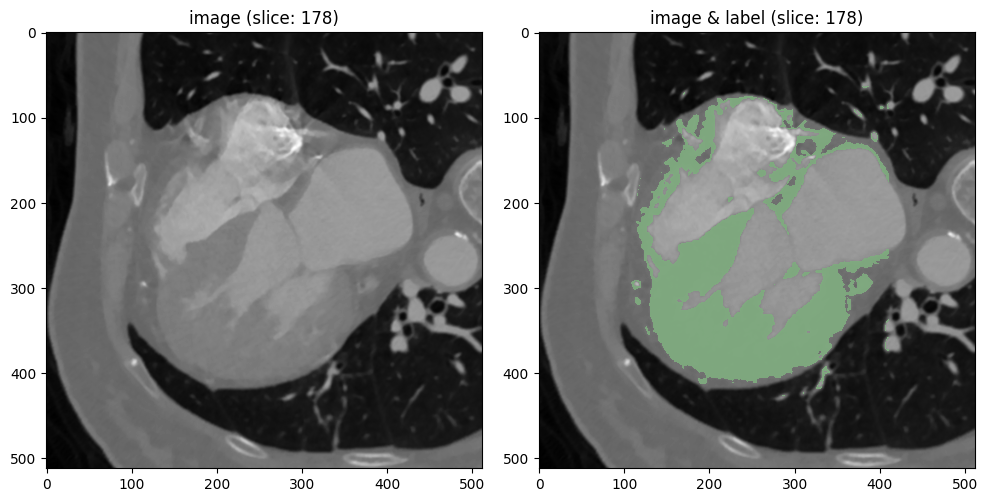

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1000
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/block_06/pid_1000.nii.gz
img shape: [512, 512, 357]
img spacing: [0.36914062, 0.36914062, 0.4]
lbl shape: [512, 512, 357]
lbl spacing: [0.36914062, 0.36914062, 0.4]
lbl ids: [0. 1.]


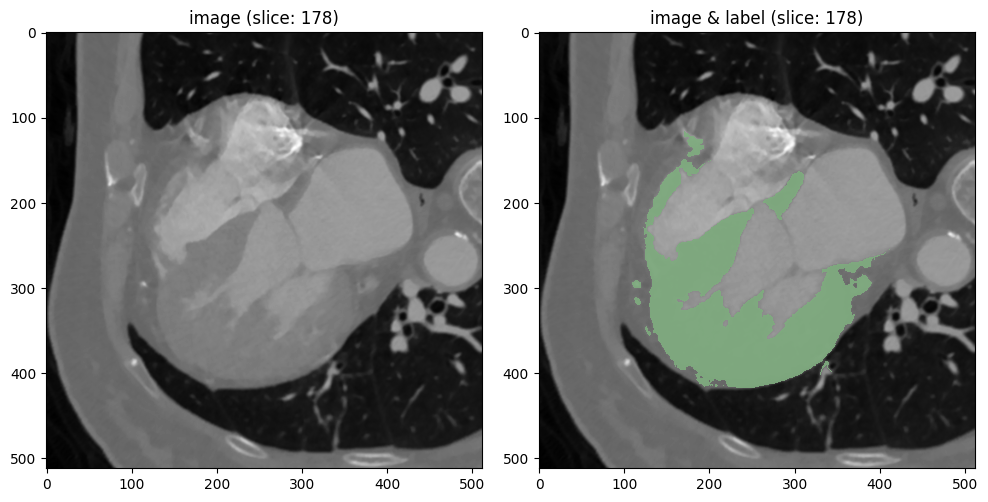

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(


In [40]:
data_info_df = get_data_info(data_dicts)

In [41]:
data_info_df

,pid,img_shape,img_space,lbl_shape,lbl_space,lbl_ids
0,pid_1000,"[512, 512, 357]","[0.36914062, 0.36914062, 0.4]","[512, 512, 357]","[0.36914062, 0.36914062, 0.4]","[0.0, 1.0]"
1,pid_1000,"[512, 512, 357]","[0.36914062, 0.36914062, 0.4]","[512, 512, 357]","[0.36914062, 0.36914062, 0.4]","[0.0, 1.0]"
2,pid_1000,"[512, 512, 357]","[0.36914062, 0.36914062, 0.4]","[512, 512, 357]","[0.36914062, 0.36914062, 0.4]","[0.0, 1.0]"
3,pid_1000,"[512, 512, 357]","[0.36914062, 0.36914062, 0.4]","[512, 512, 357]","[0.36914062, 0.36914062, 0.4]","[0.0, 1.0]"


In [ ]:
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
data_shape_df.mean()

w    512.0
h    512.0
s    343.2
dtype: float64

In [ ]:
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])
data_space_df.mean()

x    0.376563
y    0.376563
z    0.440000
dtype: float32

## Statcics

In [7]:
base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=data_dicts,
    transform=base_tf
)

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 8/8 [00:57<00:00,  7.24s/it]


In [10]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
s = DatasetSummary(ds)
s.calculate_percentiles(min_percentile=5,max_percentile=99)
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [19]:
space = get_target_spacing(s)

check value: 1.3128205128205128


In [11]:
print('data target space:')
data_target_space

data target space:


(0.380859375, 0.380859375, 0.5)

In [ ]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', 'min_percentile (0.5%)', 'max_percentile (99.5%)']
)
data_intensities_statcics

data intensities statcics:


,min,med,max,mean,std,min_percentile (0.5%),max_percentile (99.5%)
0,-813.0,119.0,1613.0,133.014481,78.189308,32.0,294.0


## utils

In [22]:
from pathlib import PurePath

from tqdm import tqdm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import numpy as np

mpl.rcParams['figure.dpi'] = 300


def get_slicer_cmap(num_classes):
    '''get 3d slicer cmap (7 label for cardiac)'''
    colorarray = [
        [128 / 256, 174 / 256, 128 / 256, 1],
        [241 / 256, 214 / 256, 145 / 256, 1],
        [177 / 256, 122 / 256, 101 / 256, 1],
        [111 / 256, 184 / 256, 210 / 256, 1],
        [216 / 256, 101 / 256, 79 / 256, 1],
        [221 / 256, 130 / 256, 101 / 256, 1],
        [144 / 256, 238 / 256, 144 / 256, 1],
    ]
    return ListedColormap(colorarray[:num_classes])


def get_data(files, transform):
    ds = CacheDataset(
        data=files,
        transform=transform,
        num_workers=2
    )
    return ds


def show_data(data, alpha=0.5):
    num_classes = 2
    col_num = 2
    row_num = len(data_dicts)

    plt.figure("check", (10,5*row_num))
    subplot_idx = 1
    for d in data:
        # get pid
        pid = PurePath(d['image_meta_dict']['filename_or_obj']).parts[-1].split('.')[0]

        # get img and lbl
        slice_idx = d['image'].shape[-1]//2
        img = d['image'][0,:,:,slice_idx]
        lbl = d['label'][0,:,:,slice_idx]
        lbl_msk = np.ma.masked_where(lbl == 0, lbl)

        # show img
        plt.subplot(row_num, col_num, subplot_idx)
        plt.title(f"{pid} (slice: {slice_idx})")
        plt.imshow(img, cmap='gray')
        # update subplot idx
        subplot_idx+=1

        # show img with lbl
        plt.subplot(row_num, col_num, subplot_idx)
        plt.title(f"{pid} (slice: {slice_idx})")
        plt.imshow(img, cmap='gray')
        plt.imshow(
            lbl_msk,
            get_slicer_cmap(num_classes),
            interpolation='none',
            alpha=alpha,
            vmin=1,
            vmax=num_classes
        )
        # update subplot idx
        subplot_idx+=1

    plt.tight_layout()
    plt.show()

## Transform

In [20]:
space = [0.38,0.38,0.5]
a_min = -42 #s.data_min_percentile
a_max = 423 #s.data_max_percentile
transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          ToTensord(keys=["image", "label"])
      ]
  )

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [ ]:
data = None
del data
data = get_data([data_dicts[0]], transform)

Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

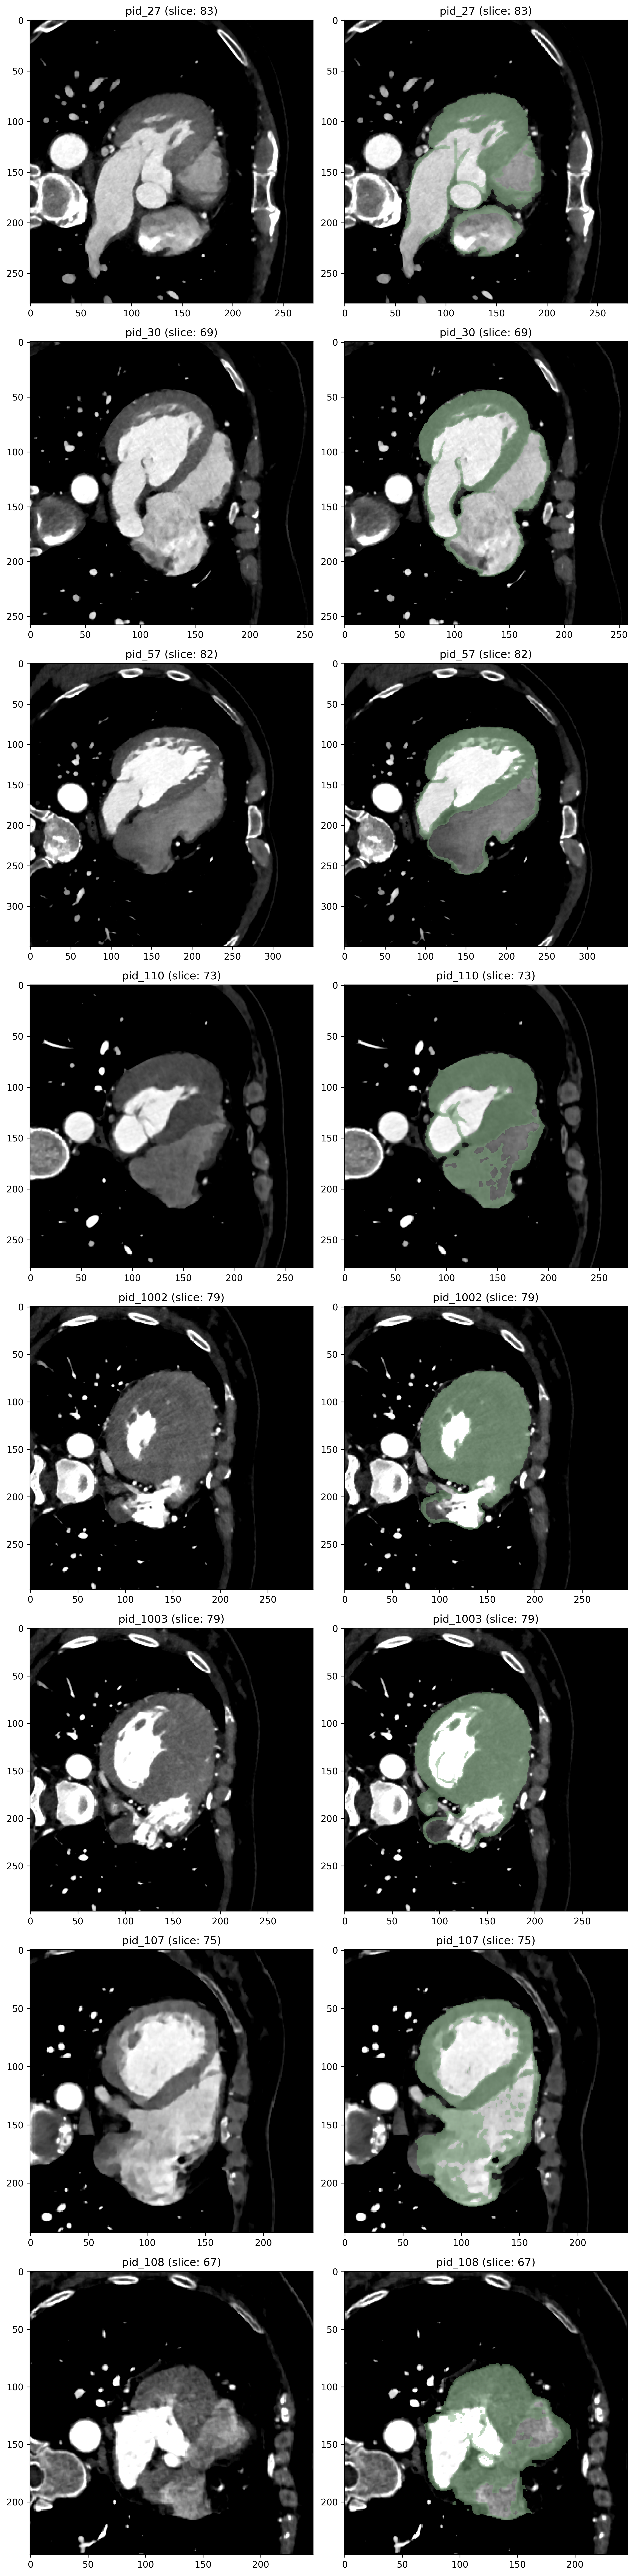

In [ ]:
show_data(data)